In [1]:
from pathlib import Path
import time
from itertools import product

import cv2
import h5py
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter, rotate

import torch
from tqdm.auto import tqdm

import sklearn.cluster as skc
import sklearn.metrics as skm
from torch_dct import dct_2d
from scipy.ndimage import zoom
import scipy.signal as sps

from sklearn import metrics
from scipy import stats

import arpesnet as an
from arpesnet import transform as tr
# import knano.transform as tr
# import neuralarpes as na
# from neuralarpes import transform as tr

# import dataloader as dl




In [2]:
seed = 192
rng = np.random.default_rng(seed)

In [3]:
# import dataloader as dl
# filename = "Cleave3_14.h5"        # 2,92 Gb
# filename = "GPScan_5.h5"          # 0,66 Gb
filename = "GPScan_133_1.h5"      # 3,96 Gb
# filename = "gr_flake_full.h5"     # 0,49 Gb
# filename = "gr_flake_256.h5"      # 0,44 Gb

# filename = "misfit_Se3d_512.h5"   # 0, Gb
# filename = "misfit_Se3d_1024.h5"   # 0, Gb
# filename = "misfit_Se3d_full.h5"  # 0, Gb
# filename = "misfit_Bi5d_512.h5"   # 0, Gb
# filename = "misfit_Bi5d_1024.h5"   # 0, Gb
# filename = "misfit_Bi5d_full.h5"  # 0, Gb
# filename = "misfit_VB_512.h5"   # 0, Gb
# filename = "misfit_VB_1024.h5"   # 0, Gb
# filename = "misfit_VB_full.h5"  # 0, Gb


path = Path(os.path.dirname(os.getcwd())) / "Encoded Data" / f"{filename[:-3]}.txt"

dataIn = torch.load(path)


C:\Users\Alexa\AppData\Local\Temp\ipykernel_2540\2374403870.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataIn = torch.load(path)


In [4]:
shapes = {
    "Cleave3_14.h5"      : [164, 144],
    "GPScan_5.h5"        : [[],[]],
    "GPScan_133_1.h5"    : [142, 161],
    "gr_flake_full.h5"   : [49, 39],
    "gr_flake_256.h5"    : [49, 39],
    "misfit_Se3d_512.h5" : [[],[]],
    "misfit_Se3d_full.h5": [[],[]],
    "misfit_VB_full.h5"  : [[0, 789],[700, 900]],
}

shape = shapes[filename]


In [5]:
# Klargøring af ARPES
print("Loading trainer")
trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\General coding stuff\ARPES_on_the_fly_arpesnet_206c328\trained_model\arpesnet_n2n_4k.pth"
# trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\Deres\ARPES_on_the_fly_arpesnet_206c328\trained_by_me\arpesnet_60epochs_001.pt"
trainer = an.core.load_trainer(trainerPath)
print("Trainer loaded\n")

encoder = trainer.encoder
decoder = trainer.decoder

encoder.eval()
decoder.eval()

INPUT_SHAPE = (256, 256)
NORM_RANGE = (0, 100)

preprocess = an.transform.Compose(
    [an.transform.Resize(INPUT_SHAPE), an.transform.NormalizeMinMax(*NORM_RANGE)]
)
testing_augmentations = an.transform.Compose(
    [
        an.transform.Resize(INPUT_SHAPE),
        an.transform.NormalizeMinMax(*NORM_RANGE),
    ]
)

def useARPES_on_img(img, pri=False, Numpy=True, decode=True):
    img = torch.from_numpy(img)
    img = preprocess(img)
    if(pri): print(img)
    img = testing_augmentations(img)
    if(not decode): rec = encoder(img.unsqueeze(0))
    else: rec = decoder(encoder(img.unsqueeze(0)))

    if(Numpy):
        img = img.detach().squeeze().cpu().numpy()
        try: rec = rec.detach().squeeze().cpu().numpy()
        except: pass

    return img, rec
print("Machine learning reconstruction is ready")

c:\Users\Alexa\anaconda3\lib\site-packages\arpesnet\core.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(filepath)
c:\Users\Alexa\anaconda3\lib\site

Loading trainer
GPU not available, using CPU
Trainer loaded

Machine learning reconstruction is ready


In [6]:
data = {"4k_En": [], "4k_De": []}

for s in tqdm(dataIn):
    data["4k_En"].append(s.detach().squeeze().cpu().numpy())
    data["4k_De"].append(decoder(s).detach().squeeze().cpu().numpy())

# data["4k_En"] = np.array(data["4k_En"]).reshape((shape[0]*shape[1], 512))
# data["4k_De"] = np.array(data["4k_De"]).reshape((shape[0]*shape[1], 256*256))

  0%|          | 0/22862 [00:00<?, ?it/s]

In [7]:
data["4k_En"] = np.array(data["4k_En"])
data["4k_De"] = np.array(data["4k_De"])

In [8]:
print(data["4k_De"].shape)
data["4k_En"] = data["4k_En"].reshape((shape[0]*shape[1], 512))
data["4k_De"] = data["4k_De"].reshape((shape[0]*shape[1], 256*256))

(22862, 256, 256)


In [16]:
kres = {}
ktime = {}
kscore = {}
n_clusters = 4
for k,v in tqdm(data.items()):
    init_idxs = skc.kmeans_plusplus(data[k], n_clusters, random_state=seed)[1]
    t0 = time.time()
    init_clusters = v[init_idxs]
    km = skc.KMeans(n_clusters=n_clusters, init=init_clusters)
    kres[k] = km.fit(v)
    ktime[k] = time.time()-t0
    kscore[k] = skm.silhouette_score(v, kres[k].labels_)
    # print(f"Score = {kscore[k]}")
    print(f"tid = {ktime[k]}\n")

  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


tid = 0.14771294593811035



c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


tid = 64.93133640289307



In [17]:
for k,v in tqdm(data.items()):
    print(f"Score = {kscore[k]}")
    print(f"tid = {ktime[k]}\n")

  0%|          | 0/2 [00:00<?, ?it/s]

Score = 0.2723720371723175
tid = 0.14771294593811035

Score = 0.34909898042678833
tid = 64.93133640289307



In [18]:
def showCoord(coords=None, index=None, imgs=None, title=None):
    showImgs = []

    if(coords == None and index == None and imgs != None):
        grid = [[name for _, name in imgs]]
        fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
        fig.subplots_adjust(wspace=0.2)
        if(title != None): fig.suptitle(title, fontsize=16)

        showImgs = [img for img, _ in imgs]
        names = np.copy(grid[0])
    else:
        print("****************************************************************")
        print("Showing the default img: index = 0")
        print("****************************************************************")
        showCoord(index=0)
        return None
    
    for nr, key in enumerate(grid[0]):
        clim = showImgs[nr].min(), showImgs[nr].max()
        axes[key].imshow(showImgs[nr], cmap="viridis", clim=clim, origin="lower")
        axes[key].set_title(names[nr])
        axes[key].invert_yaxis()

In [19]:
def entropy(img):
    n_clusters = np.max(img)+1
    t = dict([]*(n_clusters))
    bigSum = 0
    for clus in range(n_clusters):
        mask = np.where(img == clus, 1, 0)
        conv = sps.convolve(mask, np.ones((3,3)))
        s = np.sum(np.where(mask == 0, conv[1:-1, 1:-1], 0))

        try:
            s = s / (img.size - np.sum(mask))**(1/2)
        except: 
            s = 0

        t[f"{clus}"] = s
        bigSum += s
        # print(img.size)

    return bigSum, t

print(filename + ":")
for k,v in data.items():
    compMask = kres[k].labels_
    # print(f"Score with {k} fit mask:")
    # s = skm.silhouette_score(data["raw"], compMask); print(f"raw data SC-score = {s}")
    # s = skm.silhouette_score(data["DCT32"], compMask); print(f"DCT32 data SC-score = {s}")
    # s = skm.silhouette_score(data["4k"], compMask); print(f"4k data SC-score = {s}")
    # print()
    # s = skm.calinski_harabasz_score(data["raw"], compMask); print(f"raw data CH-score = {s}")
    # s = skm.calinski_harabasz_score(data["DCT32"], compMask); print(f"DCT32 data CH-score = {s}")
    # s = skm.calinski_harabasz_score(data["4k"], compMask); print(f"4k data CH-score = {s}")
    # print()
    # s = skm.davies_bouldin_score(data["raw"], compMask); print(f"raw data DB-score = {s}")
    # s = skm.davies_bouldin_score(data["DCT32"], compMask); print(f"DCT32 data DB-score = {s}")
    # s = skm.davies_bouldin_score(data["4k_En"], compMask); print(f"4k data DB-score = {s}")
    # print("\n\n")
    s,_ = entropy(compMask.reshape(shape)); print(f"{k} data entropy-score = {s}")
    kscore[k] = s
    # print("\n")

GPScan_133_1.h5:
4k_En data entropy-score = 116.44595983260938
4k_De data entropy-score = 137.30180004773968


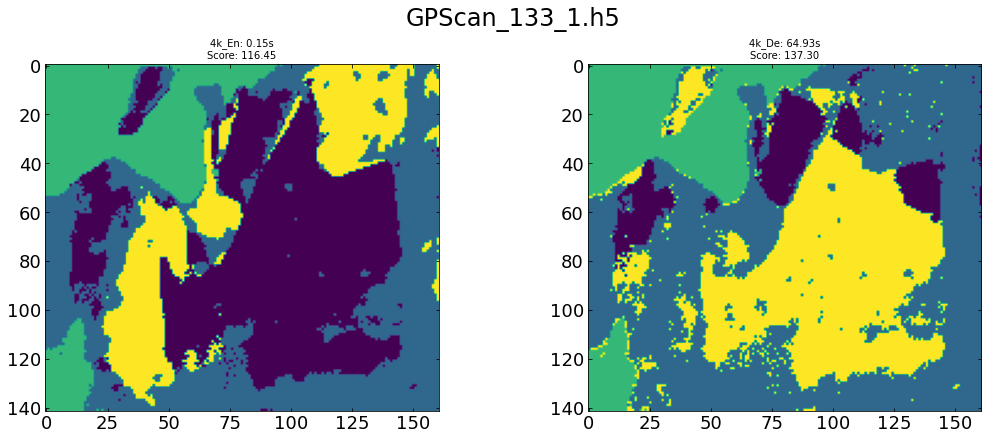

In [20]:
plt.rc("axes", labelsize=20, titlesize=10)   # skriftstørrelse af xlabel, ylabel og title
plt.rc("xtick", labelsize=18, top=True, direction="in")  # skriftstørrelse af ticks, vis også ticks øverst og vend ticks indad
plt.rc("ytick", labelsize=18, right=True, direction="in") # samme som ovenstående
plt.rc("legend", fontsize=12) # skriftstørrelse af figurers legends
plt.rcParams["font.size"] = "20"

fig,ax = plt.subplots(1,len(data), figsize=(15,6), layout='constrained')
fig.suptitle(f"{filename}")
# shape = tuple(axisData["dims"][:2])
for i,(k,v) in enumerate(kres.items()):
    ax[i].imshow(v.labels_.reshape(shape),cmap='viridis',aspect='equal')
    ax[i].set_title(f"{k}: {ktime[k]:.2f}s\nScore: {kscore[k]:.2f}")

In [21]:
print(int("s"))
# fig, ax = plt.subplots(len(kres),n_clusters,figsize=(15,6))
# for i, (k, v) in enumerate(kres.items()):
#     centers = [np.mean(data['raw'][v.labels_==i],axis=0) for i in range(n_clusters)]
#     for j, c in enumerate(centers):
#         ax[i,j].imshow(c.reshape((256,256)),cmap='viridis',aspect='equal',origin='lower')
#         ax[i,j].axis('off')
#         ax[i,j].set_title(f"{k} {j}")



ValueError: invalid literal for int() with base 10: 's'

In [ ]:
# border pre-selection

1


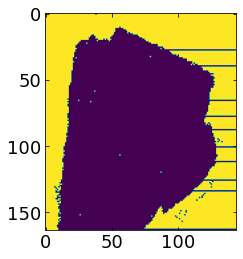

In [ ]:
# print(int("s"))
# n_clusters = 2
# km = skc.KMeans(n_clusters=n_clusters)
# filter_res = km.fit(data['4k_En'])
# plt.figure()
# plt.imshow(filter_res.labels_.reshape(shape),cmap='viridis',aspect='equal')
# print(filter_res.labels_.reshape(shape)[0,0])

In [ ]:
# masked_spectra = xarr.values.reshape((-1,256,256))
# masked_spectra[filter_res.labels_.reshape(shape)==0] = np.zeros((256,256))


In [ ]:
# filter_res.labels_.shape

# AOIMask = (filter_res.labels_[int(shape[0]*shape[1]/2) + int(shape[0]/2)]+0)%2
# print(AOIMask)

0


In [ ]:
#Fjerner kanten
# for nr, (mask) in enumerate(tqdm(filter_res.labels_)):
#     if mask == (AOIMask+1)%2:
#         data["4k_En"][nr] = np.zeros((512)).flatten()
#         data["4k_De"][nr] = np.zeros((256,256)).flatten()


  0%|          | 0/23616 [00:00<?, ?it/s]

# cluster masked data

In [ ]:
kres = {}
ktime = {}
kscore = {}
kscoreSample = {}
n_clusters = 4
for k,v in tqdm(data.items()):
    if(True or k == "4k"):
        init_idxs = skc.kmeans_plusplus(data[k], n_clusters, random_state=seed)[1]
        t0 = time.time()
        init_clusters = v[init_idxs]
        km = skc.KMeans(n_clusters=n_clusters, init=init_clusters)
        kres[k] = km.fit(v)
        ktime[k] = time.time()-t0
        # kscore[k] = skm.silhouette_score(v, kres[k].labels_)
        kscoreSample[k] = skm.silhouette_samples(v, kres[k].labels_)

print(kscore)

  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
c:\Users\Alexa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


{}


4k_En:
score = 0.47933951020240784
actual mean = 0.14930690682510028

1.0
4k_De:
score = 0.5041018724441528
actual mean = 0.18976547095527185

1.0


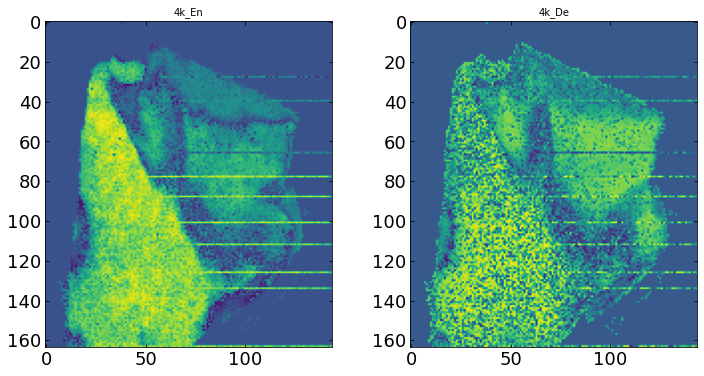

In [ ]:
for k, v in kscoreSample.items():
    kscore[k] = np.mean(kscoreSample[k])
    count = np.sum(np.where(v>0.95, 0, 1))
    mean = np.sum(v-1) / count + 1
    print(f"{k}:")
    print(f"score = {kscore[k]}")
    print(f"actual mean = {mean}")
    print(f"tid = {ktime[k]}\n")
    # kscoreSample[k] = np.where(v>0.7, 0, v)
    # print(v[0])
    # kscoreSample[k] = np.where(v==0, 1, v)

for k, v in kres.items():
    print(f"Entropy = {entropy(v.reshape(shape))}")
showCoord(imgs=[[np.reshape(v, shape), k] for k, v in kscoreSample.items()])

NameError: name 'axisData' is not defined

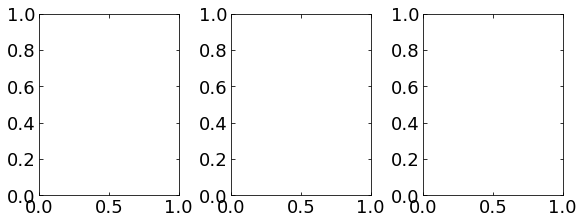

In [ ]:
fig,ax = plt.subplots(1,len(data.keys())+1, figsize=(8,3),layout='constrained')
selected = {k:v for k,v in kres.items() if k not in ['simple','noise','denoiser']}
for i_,(k,v) in enumerate(selected.items()):
    i = i_ +1
    img = v.labels_.reshape(shape).astype(float)
    img[img==1] = np.nan
    ax[i].imshow(img,cmap='viridis',aspect='equal')#,origin='lower')
    if k == '4k_En':
        ax[i].set_title(f"ARPESNet\nScore: {kscore[k]:.2f}")
    elif k == '4k_De':
        ax[i].set_title(f"ARPESNet decoded\nScore: {kscore[k]:.2f}")
    elif k == 'raw':
        ax[i].set_title(f"Raw\nScore: {kscore[k]:.2f}")
    else:
        ax[i].set_title(f"{k}\nScore: {kscore[k]:.2f}")
    ax[i].axis('off')
    ax[i].text(30,3,f"({'abcdefghijklmnopq'[i]})",color='k',fontsize=12,ha='center', va='center')
# imap = xarr.sum(['energy','angle'])
# # imap.values[filter_res.labels_.reshape(shape) == (AOIMask+1)%2] = np.nan #edge filter
# ax[0].imshow(imap.values,cmap='viridis',aspect='equal')#,origin='lower')
# # imap.plot.imshow(ax=ax[0], cmap='viridis', robust=True, add_colorbar=False)
# ax[0].set_title('Intensity map')
# ax[0].axis('off')
# ax[0].text(30,3,f"(a)",color='k',fontsize=12,ha='center', va='center')
# fig.savefig('figs/fig7_panels.svg',dpi=300, bbox_inches='tight', transparent=True, format='svg')


In [ ]:
fig, ax = plt.subplots(len(kres),n_clusters, figsize=(8,8))
for i, (k, v) in enumerate(kres.items()):
    centers = [np.mean(data2['raw'][v.labels_==i], axis=0) for i in range(n_clusters)]
    for j, c in enumerate(centers):
        ax[i,j].imshow(c.reshape((256,256)), cmap='viridis', aspect='equal', origin='lower')
        ax[i,j].axis('off')
        ax[i,j].set_title(f"{k} {j}")